<a href="https://colab.research.google.com/github/krissnx/DeepLab-INFO0702/blob/main/deeplab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import PIL.Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import UpSampling2D, MaxPooling2D
import matplotlib.image as mpimg
from skimage.io import imread, imshow
from skimage.transform import resize
import cv2
import os
from tensorflow.keras.preprocessing.image import load_img
import pandas as pd
import random
from tqdm import tqdm
import glob
from google.colab.patches import cv2_imshow
from keras import backend as K
from keras.layers import Layer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_mask_images_paths = []
dirpath_train = "/content/drive/MyDrive/Projet_INFO0702/mask_images/train/"
dirnames = os.listdir(dirpath_train)
for i in dirnames:
  if not(i.startswith(".")) :
    filenames = os.listdir(dirpath_train + i)
    for j in filenames:
      if j.endswith("_label.png") == False:
        j = j[:-4] + "_label.png"
      if j.startswith("train"):
        train_mask_images_paths.append(dirpath_train + i + "/" + j)

test_mask_images_paths = []
dirpath_test = "/content/drive/MyDrive/Projet_INFO0702/mask_images/test/"
dirnames = os.listdir(dirpath_test)
for i in dirnames:
  if not(i.startswith(".")) :
    filenames = os.listdir(dirpath_test + i)
    for j in filenames:
      if j.endswith("_label.png") == False:
        j = j[:-4] + "_label.png"
      if j.startswith("test"):
        test_mask_images_paths.append(dirpath_test + i + "/" + j)

train_original_images_paths = []
dirpath_train = "/content/drive/MyDrive/Projet_INFO0702/original_images/train/"
dirnames = os.listdir(dirpath_train)
for i in dirnames:
  if not (i.startswith(".")) :
    filenames = os.listdir(dirpath_train + i)
    for j in filenames:
      if j.startswith("train") :
        train_original_images_paths.append(dirpath_train + i + "/" + j)

test_original_images_paths = []
dirpath_test = "/content/drive/MyDrive/Projet_INFO0702/original_images/test/"
dirnames = os.listdir(dirpath_test)
for i in dirnames:
  if not (i.startswith(".")) :
    filenames = os.listdir(dirpath_test + i)
    for j in filenames:
      if j.startswith("test") :
        test_original_images_paths.append(dirpath_test + i + "/" + j)

train_mask_images_paths = sorted(train_mask_images_paths, key=lambda x: x[0:len(x)-10])
test_mask_images_paths = sorted(test_mask_images_paths, key=lambda x: x[0:len(x)-10])
train_original_images_paths = sorted(train_original_images_paths,  key=lambda x: x[0:len(x)-4])
test_original_images_paths = sorted(test_original_images_paths,  key=lambda x: x[0:len(x)-4])

number_of_images, number_of_masks = len(train_original_images_paths) + len(test_original_images_paths), len(train_mask_images_paths) + len(test_mask_images_paths)
print(f"Il y a {number_of_images} images et {number_of_masks} masques dans la dataset")
print(f"Exemple image: \n {train_original_images_paths[0]}")
print(f"Exemple masque: \n {train_mask_images_paths[0]}")


Il y a 503 images et 503 masques dans la dataset
Exemple image: 
 /content/drive/MyDrive/Projet_INFO0702/original_images/train/Apple_Rust/train_Apple_Rust_17.jpg
Exemple masque: 
 /content/drive/MyDrive/Projet_INFO0702/mask_images/train/Apple_Rust/train_Apple_Rust_17_label.png


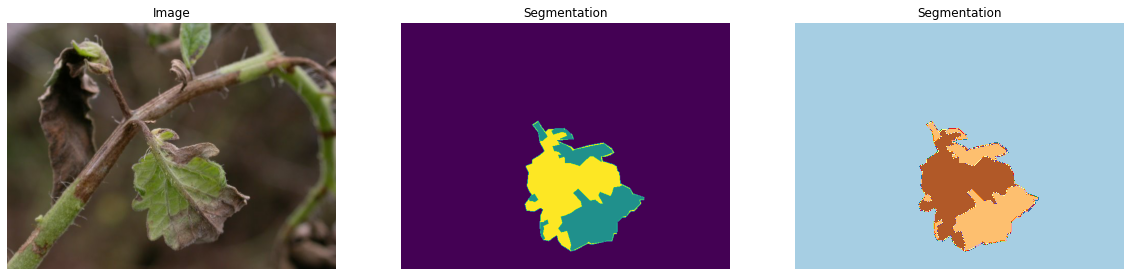

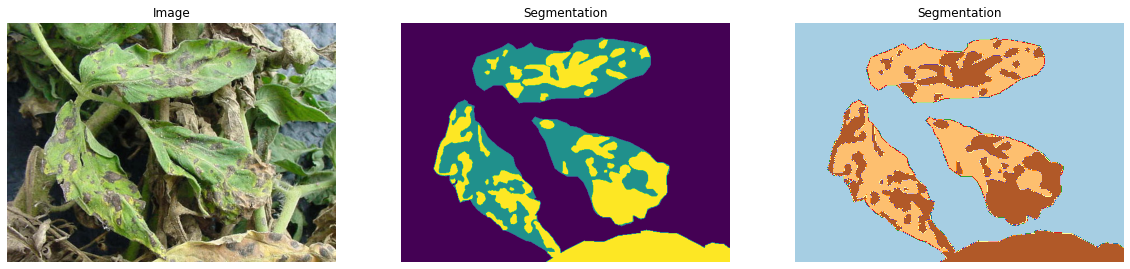

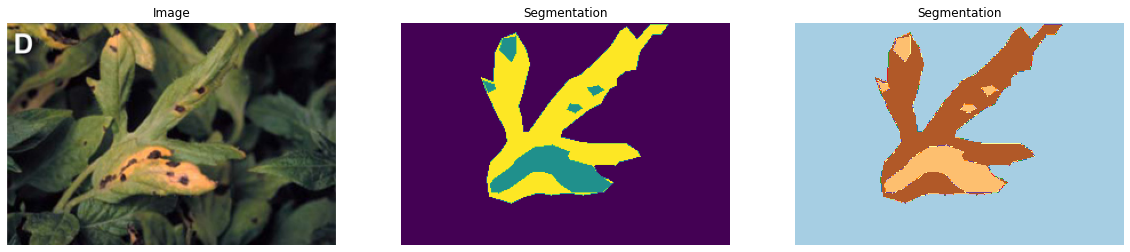

In [ ]:
import random
number_of_samples = len(train_original_images_paths)

for i in range(3):
    N = random.randint(0, number_of_samples - 1)

    img = np.asarray(PIL.Image.open(train_original_images_paths[N]))
    # img = cv2.resize(img, (224,224))
    mask = np.asarray(PIL.Image.open(train_mask_images_paths[N]))
    # mask = cv2.resize(mask, (224,224))

    fig, arr = plt.subplots(1, 3, figsize=(20, 8))
    arr[0].imshow(img)
    arr[0].set_title('Image')
    arr[0].axis("off")
    arr[1].imshow(mask)
    arr[1].set_title('Segmentation')
    arr[1].axis("off")    
    arr[2].imshow(mask, cmap='Paired')
    arr[2].set_title('Segmentation')
    arr[2].axis("off")

In [ ]:
def read_image(image_path, mask_path):
    
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (256, 256), method='nearest')

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (256, 256), method='nearest')
    
    return image, mask


def data_generator(image_paths, mask_paths, buffer_size, batch_size):
    
    image_list = tf.constant(image_paths) 
    mask_list = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().shuffle(buffer_size).batch(batch_size)
    
    return dataset


batch_size = 32
buffer_size = 500

train_dataset = data_generator(train_original_images_paths, train_mask_images_paths, buffer_size, batch_size)
test_dataset = data_generator(test_original_images_paths, test_mask_images_paths, buffer_size, batch_size)

In [ ]:
for train_images, train_masks in train_dataset:
    break
for test_images, test_masks in test_dataset:
    break
    

for i in range(2):
    N = random.randint(0, batch_size-1)
    
    images = [train_images[N], test_images[N]]
    masks = [train_masks[N], test_masks[N]]
    title = ['Train Image','Test Image', 'Train Mask', 'Test Mask']

    fig, arr = plt.subplots(1, 3, figsize=(20, 8))
    arr[0].imshow(images[i])
    arr[0].set_title(title[i])
    arr[0].axis("off")
    arr[1].imshow(masks[i])
    arr[1].set_title(title[i+2])
    arr[1].axis("off")
    arr[2].imshow(masks[i], cmap='Paired')
    arr[2].set_title(title[i+2])
    arr[2].axis("off")

In [ ]:
def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
        )(block_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x



def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output



def DeeplabV3(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),interpolation="bilinear",)(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    model = tf.keras.Model(inputs=model_input, outputs=model_output)
    
    return model



img_height = 256
img_width = 256
num_channels = 3
filters = 32
n_classes = 23

model = DeeplabV3(img_height, num_classes=23)
model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)
batch_size = 32
epochs = 30

history = model.fit(train_dataset,  
                    epochs = epochs, 
                    verbose=1, 
                    callbacks = [callback, reduce_lr], 
                    batch_size = batch_size, 
                    shuffle = True)


Epoch 1/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5228

15/15 [==============================] - 136s 879ms/step - loss: nan - accuracy: 0.5228 - lr: 0.0010
Epoch 2/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 701ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 3/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 710ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 4/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 713ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 5/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 696ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 6/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 697ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 7/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 696ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 8/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 704ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 9/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 702ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 10/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 706ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 11/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 707ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 12/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 702ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 13/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 10s 692ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 14/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 700ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 15/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 707ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 16/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 702ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 17/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 698ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 18/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 705ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 19/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 700ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 20/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 701ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 21/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 706ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 22/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 700ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 23/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 704ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 24/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 704ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 25/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 695ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 26/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 705ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 27/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 700ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 28/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 708ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 29/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 709ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010
Epoch 30/30
15/15 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5620

15/15 [==============================] - 11s 704ms/step - loss: nan - accuracy: 0.5620 - lr: 0.0010


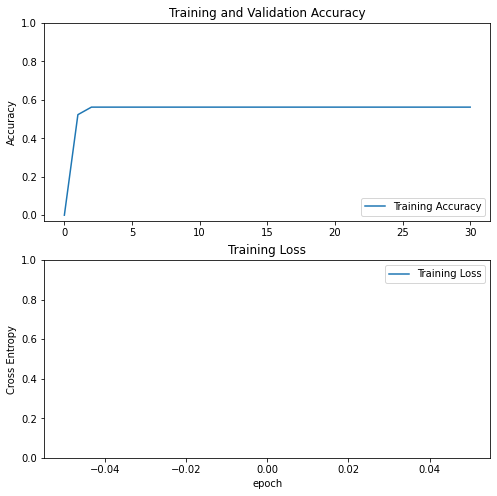

In [ ]:
acc = [0.] + history.history['accuracy']
# val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
# val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
train_loss, train_accuracy = model.evaluate(train_dataset, batch_size = 32)
test_loss, test_accuracy = model.evaluate(test_dataset, batch_size = 32)

2/2 [==============================] - 47s 2s/step - loss: nan - accuracy: 0.5231


In [ ]:
print(f'Model Accuracy on the Training Dataset: {round(train_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Test Dataset: {round(test_accuracy * 100, 2)}%')

Model Accuracy on the Training Dataset: 56.2%
Model Accuracy on the Test Dataset: 52.31%
